In [1]:
# If not installed, run this cell. It is needed for access to GEE
#!pip install ee
#!pip show ee

In [2]:
# If not installed, run this cell. It helps visualization of data
#!pip install geemap
#!pip show geemap

In [3]:
# Import libraries
import ee, datetime, pandas as pd, geemap, ipyleaflet, ipywidgets as widgets, matplotlib.pyplot as plt
import calendar
# from IPython.display import Image
from otherfunctions import water_balance, ee_array_to_df
from functools import partial

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jvg')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [ ]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
hydrobasins = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_3')
hybas_id = "HYBAS_ID"
Map = geemap.Map()
Map.addLayer(hydrobasins, {}, 'HydroBasins')

In [6]:
output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = ipyleaflet.WidgetControl(widget=output_widget, position="bottomright")
Map.add_control(output_control)

In [7]:
# This ID and lat and lon will be identified through the interative map above by clicking on the basin of your interest.
# See the widget on the bottom right side of the map
# Define the basin and location of interest
selected_basin_id = None
lat = None
lon = None

def remove_layer(pre_name):
    layer_names = Map.layers # Get the list of layer names
    layers = Map.layers[:]  # Get the list of layers
    names = [layer.name for layer in layer_names]  # Extract layer names

    for item in names:
        if pre_name in item: # Check if the name is in the item
            index = names.index(item)  # Get the index of the name
            layer = layer_names[index]  # Retrieve the layer at the index
            Map.remove(layer)  # Remove the layer from the map    
            return Map.layers[:]
  
    return layers

# Function to identify the ID of the basin of interest by clicking on the map over the feature of the HydroSHEDS
def handle_interaction(**kwargs):
    global selected_basin_id, lat, lon, poi, poi_ft

    latlon = kwargs.get('coordinates')
    if kwargs.get('type') == 'click':
        Map.default_style = {'cursor': 'wait'}
        lat = latlon[0]
        lon = latlon[1]
        xy = ee.Geometry.Point(latlon[::-1])
        selected_fc = hydrobasins.filterBounds(xy)

        # The point location was previously defined by clicking on the map
        poi = ee.Geometry.Point(lon, lat)
        poi_ft = ee.FeatureCollection(ee.Geometry.Point(lon, lat))
        Map.addLayer(poi_ft, {'color': 'green', 'pointSize': 10}, "Point of Interest")

        with output_widget:
            output_widget.clear_output()

            try:
                pre_name = "Identified Basin: "
                Map.layers = remove_layer(pre_name)
                selected_basin_id = selected_fc.first().get(hybas_id).getInfo()
                geom = selected_fc.geometry()
                layer_name = pre_name + str(selected_basin_id)
                Map.centerObject(geom)
                Map.addLayer(ee.Image().paint(geom, 0, 2), {'palette': 'red'}, layer_name)                
                print(layer_name + "\nLat: " + str(lat) + " Long: " + str(lon))
            except Exception as e:
                print('No feature could be found')
                Map.layers = Map.layers[:]

        Map.default_style = {'cursor': 'pointer'}

Map.on_interaction(handle_interaction)
Map.default_style = {'cursor': 'pointer'}
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [8]:
# Function to determine the simulation period and the reporting period
def determine_period(start_date, end_date, warmup_yrs = 0):
    ini_date = str((int(start_date.split("-")[0]) + int(warmup_yrs))) + "-" + start_date.split("-")[1]
    if (end_date.split("-")[1]) == "12":
        fin_date = str(int(end_date.split("-")[0]) + 1) + "-01"
    else:
        fin_date = str(int(end_date.split("-")[0])) + "-" + str(int(end_date.split("-")[1]) + 1)

    if (datetime.datetime(int(ini_date.split("-")[0]), int(ini_date.split("-")[1]), 1) >= datetime.datetime(int(fin_date.split("-")[0]), int(fin_date.split("-")[1]), 1)):
        if (warmup_yrs != 0):
            print ("Start date is finally set beyond or same as the end date! Please consider the implications of the warm-up years. Remember that end date is exclusive")
        else:
            print ("Start date is finally set beyond or same as the end date! Please review your input dates. Remember that end date is exclusive")
        raise SystemExit()

    print ("Simulation period will be from " + start_date + " to " + end_date
           + "; however, outputs will be provided for " + ini_date + " to " + end_date)
    return ini_date, fin_date

In [9]:
## Initial parameters ##

# It is recommended using at least 5 years of equilibration period - warm up years. This allows the model to get the water cycling properly.
# When a proper equilibration period is incorporated, "ffcb" value is not going to impact model results
warmup_yrs = 5
start_date = '2008-01'
end_date = '2023-12'
ini_date, fin_date = determine_period(start_date, end_date, warmup_yrs)

Simulation period will be from 2008-01 to 2023-12; however, outputs will be provided for 2013-01 to 2023-12


In [10]:
######################################################
### Starting values for the water balance model - T&M
######################################################

# The recession constant (k) will be determined from hydrographs derived from the gathered streamflow datasets. For the rest of the world, k will be defined as 0.5
k_recession = 0.5 # Temporarily is defined as such

# Initial soil water storage expressed as a fraction of water holding capacity [0-1]
ffcb = 0.1 # 10%

# Base flow of the previous month (mm)
bflow_ant = 10

In [11]:
raise SystemExit("Please go to the interactive map and click on the basin and point of interest before continuing running the cells below!")

SystemExit: Please go to the interactive map and click on the basin and point of interest before continuing running the cells below!

In [12]:
# Public link to the asset whc: https://code.earthengine.google.com/?asset=projects/ee-jvg/assets/whc_fc33
zoi = hydrobasins.select(hybas_id).filter(ee.Filter.eq(hybas_id, selected_basin_id))
whc = ee.Image('projects/ee-jvg/assets/whc_fc33')
whc = whc.clip(zoi).divide(1000) # As the raster was originally multiplied by 1000
Map.addLayer(whc, {
  'min': 0,
  'max': 1000,
  'palette': [
      '#AFEEEE',
      '#E0FFFF',
      '#00FFFF',
      '#87CEEB',
      '#000080'
  ]
  },
  'Water Holding Capacity')

In [13]:
# TerraClimate layers filtered with "start_date" (inclusive) and "end_date" (exclusive) and clipped to "zoi"
terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date(start_date, fin_date)).map(lambda image: image.clip(zoi))
num_months = terraclimate.size().getInfo()
num_months

192

In [14]:
# Initial images and time to start the water balance
k = ee.Image(k_recession) # Image of recession constant
st0 = whc.multiply(ffcb) # Initial soil water storage
bf0 = ee.Image(bflow_ant) # Previous baseflow
time0 = terraclimate.first().get("system:time_start") # Define the initial time (time0) according to the start of the collection
scale = terraclimate.first().projection().nominalScale() # This is the resolution used to standardize
crs = 'EPSG:3857' # WGS 84 / Pseudo-Mercator -- Spherical Mercator, Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI

# Water balance variables
wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]

In [15]:
# Initialization of ALL bands.
# Mandatory to cast the type of the data with a .float().

# Initialization of precipitation
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# Initialization of potential evapotranspiration
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

# Initialization of runoff
initial_ro = ee.Image(0).set("system:time_start", time0).select([0], ["ro"]).float()

# Initialization of effective precipitation
initial_ep = ee.Image(0).set("system:time_start", time0).select([0], ["eprec"]).float()

# Initialization of actual evapotranspiration
initial_aet = ee.Image(0).set("system:time_start", time0).select([0], ["aet"]).float()

# Initialization of soil storage, which is considered to be a fraction of WCH
initial_st = st0.set("system:time_start", time0).select([0], ["sstor"]).float()

# Initialization of percolation
initial_pc = ee.Image(0).set("system:time_start", time0).select([0], ["perc"]).float()

# Initialization of base flow, which is considered as defined in Ulmen (2000)
initial_bf = bf0.set("system:time_start", time0).select([0], ["bflow"]).float()

# Initialization of water yield
initial_wy = ee.Image(0).set("system:time_start", time0).select([0], ["wyield"]).float()

In [16]:
# All initial bands are combined into one "ee.Image" by adding them to the first band (wy)
initial_image = initial_wy.addBands(
    ee.Image([initial_pr, initial_pet, initial_ro, initial_ep, initial_aet, initial_st, initial_pc, initial_bf])
)

# Initiatlization of list that will contain new images after each iteration
image_list = ee.List([initial_image])

In [17]:
#########################
# WATER BALANCE EXECUTION
#########################

partial_function = partial(water_balance, ee = ee, whc = whc, k = k)

# Iterate the user-supplied function to the terraclimate collection
wy_list = terraclimate.iterate(partial_function, image_list)

# Remove the initial image from our list
wy_list = ee.List(wy_list).remove(initial_image)

# Transform the list into an ee.ImageCollection
wy_coll = ee.ImageCollection(wy_list).filter(ee.Filter.date(ini_date, fin_date))

In [18]:
# Let's assign year and month to each image of the resulting image collection
wy_coll = wy_coll.map(lambda image: image.set("year", ee.Image(image).date().get("year")))
wy_coll = wy_coll.map(lambda image: image.set("month", ee.Image(image).date().get("month")))

In [19]:
# Let's have a look at the results around a location of interest
# WARNING: It crashes if the number of simulation years is greater than 11 on a monthly basis, i.e., more than 132 images.
# It will result in a df that includes data from all the reporting/printing timeperiod
arr = wy_coll.getRegion(poi, scale).getInfo()
rdf = ee_array_to_df(arr, wb_vars).sort_index()
rdf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
2013-01,1356998400000,275,68.9,206,69,68.900000,65.411003,0.100000,8.323556,214.323556
2013-02,1359676800000,373,71.1,302,71,70.900076,65.311080,0.000000,4.161778,306.161778
2013-03,1362096000000,358,72.7,286,72,71.304796,64.615875,0.000000,2.080889,288.080889
2013-04,1364774400000,70,81.6,4,66,52.289481,50.905356,0.000000,1.040444,5.040444
2013-05,1367366400000,120,78.4,32,88,78.400000,60.505356,0.000000,0.520222,32.520222
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,28,114.0,1,27,23.203016,1.365214,0.000000,0.060803,1.060803
2023-09,1693526400000,39,122.9,2,37,36.001959,0.367172,0.000000,0.030402,2.030402
2023-10,1696118400000,41,128.4,2,39,38.726433,0.093605,0.000000,0.015201,2.015201


In [20]:
# Get values of initial variables for the point of interest
copy_ii = initial_image.set('system:time_start', 0)
intial_imgs = ee.ImageCollection(ee.List([copy_ii]))
initial_arr = intial_imgs.getRegion(poi, scale).getInfo()
idf = ee_array_to_df(initial_arr, wb_vars).sort_index()
idf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0,0,0,0,6.5411,0,10,0


In [21]:
# This process is carried out to validate whether the water balance outputs were correctly calculated. Verification was done by other means
# Therefore, only if a warm-up period was not defined, this could be useful. On the contrary, the datetime of the initial variables dataframe ("idf") will not meet the antecedent datetime of dataframe "rdf"
rdff = pd.concat([idf, rdf])
#rdf.to_excel("D:\Borrar\wb_point.xlsx")
#rdff.to_csv("D:\Borrar\wb_point.csv")
rdff

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0.0,0,0,0.000000,6.541100,0.000000,10.000000,0.000000
2013-01,1356998400000,275,68.9,206,69,68.900000,65.411003,0.100000,8.323556,214.323556
2013-02,1359676800000,373,71.1,302,71,70.900076,65.311080,0.000000,4.161778,306.161778
2013-03,1362096000000,358,72.7,286,72,71.304796,64.615875,0.000000,2.080889,288.080889
2013-04,1364774400000,70,81.6,4,66,52.289481,50.905356,0.000000,1.040444,5.040444
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,28,114.0,1,27,23.203016,1.365214,0.000000,0.060803,1.060803
2023-09,1693526400000,39,122.9,2,37,36.001959,0.367172,0.000000,0.030402,2.030402
2023-10,1696118400000,41,128.4,2,39,38.726433,0.093605,0.000000,0.015201,2.015201


In [22]:
# Preparing dataframe for chart visualization
new_pd = rdf.drop(["time"], axis=1)
new_pd["year"] = rdf.apply(lambda row: row.name.split("-")[0], axis=1)
new_pd["month"] = new_pd.apply(lambda row: calendar.month_abbr[int(row.name.split("-")[1])], axis=1)
new_pd

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield,year,month
datetime,,,,,,,,,,,
2013-01,275,68.9,206,69,68.900000,65.411003,0.100000,8.323556,214.323556,2013,Jan
2013-02,373,71.1,302,71,70.900076,65.311080,0.000000,4.161778,306.161778,2013,Feb
2013-03,358,72.7,286,72,71.304796,64.615875,0.000000,2.080889,288.080889,2013,Mar
2013-04,70,81.6,4,66,52.289481,50.905356,0.000000,1.040444,5.040444,2013,Apr
2013-05,120,78.4,32,88,78.400000,60.505356,0.000000,0.520222,32.520222,2013,May
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,28,114.0,1,27,23.203016,1.365214,0.000000,0.060803,1.060803,2023,Aug
2023-09,39,122.9,2,37,36.001959,0.367172,0.000000,0.030402,2.030402,2023,Sep
2023-10,41,128.4,2,39,38.726433,0.093605,0.000000,0.015201,2.015201,2023,Oct


In [23]:
# Annual values
pd_yr = new_pd.drop("month", axis=1).groupby(["year"]).sum()
pd_yr

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
year,,,,,,,,,
2013,2280,1005.9,1357,923,739.284621,592.125809,40.683401,52.153523,1409.153523
2014,2698,999.4,1730,968,860.456038,655.969265,0.000000,5.075750,1735.075750
2015,2313,1039.3,1326,987,860.697021,557.405179,17.151536,12.864891,1338.864891
2016,2259,1051.2,1273,986,838.018018,582.916963,29.020456,29.642237,1302.642237
2017,2292,1051.7,1319,973,807.881410,571.142797,41.181639,38.874143,1357.874143
2018,2328,978.8,1409,919,775.804711,587.714818,26.104788,28.626331,1437.626331
2019,2828,1009.1,1895,933,765.707272,581.636736,43.806585,41.769268,1936.769268
2020,2084,1125.0,1119,965,738.266602,509.205567,96.567289,75.238647,1194.238647
2021,2283,1097.5,1351,932,699.093361,545.775417,102.293361,106.780060,1457.780060


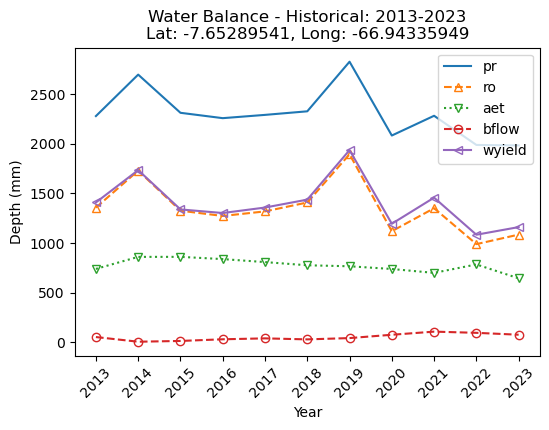

In [24]:
# Plot of yearly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_yr.drop(["pet", "eprec", "sstor", "perc"], axis=1).columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-"]
markers = ["", "^", "v", "o", "<"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_yr[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [25]:
# Monthly values
pd_month = new_pd.drop("year", axis=1).groupby(["month"], sort=False).mean()
pd_month

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
month,,,,,,,,,
Jan,306.545455,75.463636,231.181818,75.363636,75.015032,64.422545,0.081908,4.913978,236.095797
Feb,326.454545,68.945455,257.636364,68.818182,68.481608,64.222272,0.081881,2.497929,260.134293
Mar,329.363636,77.654545,251.909091,77.454545,77.151277,64.019003,0.009091,1.253510,253.162601
Apr,228.181818,77.181818,152.363636,75.818182,74.252988,62.762804,0.072824,0.663167,153.026804
May,156.909091,83.718182,73.454545,83.454545,81.387995,62.568980,0.000000,0.331584,73.786129
Jun,56.363636,86.727273,8.181818,48.181818,21.275628,35.717335,0.000000,0.165792,8.347610
Jul,43.363636,105.390909,2.363636,41.000000,18.864554,17.054616,0.000000,0.082896,2.446532
Aug,38.909091,110.918182,1.909091,37.000000,26.419699,6.474316,0.000000,0.041448,1.950539
Sep,86.181818,109.381818,4.363636,81.818182,77.556420,9.503463,0.000000,0.020724,4.384360


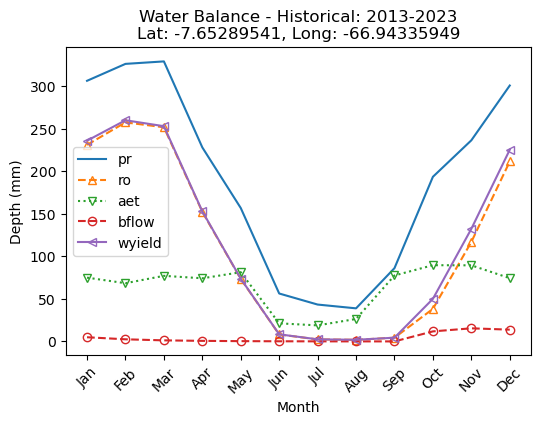

In [26]:
# Plot of monthly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_month.drop(["pet", "eprec", "sstor", "perc"], axis=1).columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-"]
markers = ["", "^", "v", "o", "<"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_month[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [27]:
def create_annual_composite(year):
  # Reduce image collection for the year
  annual_image = ee.ImageCollection(wy_coll.select(wb_vars) \
                          .filterMetadata('year', 'equals', year) \
                          .set('year', year)).sum().float()

  # Rename bands with original names
  annual_image = annual_image.rename(ee.List(wb_vars))

  return annual_image

# Define years from image collection
years = ee.List(wy_coll.aggregate_array('year')).distinct().sort()

# Create annual image collection
annual_ic = ee.ImageCollection.fromImages(years.map(lambda year: create_annual_composite(ee.Number(year))))

In [29]:
var_to_show = "ro" # wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]
img_to_show = annual_ic.select(var_to_show)

# Define arguments for the getVideoThumbURL function parameters.
videoArgs = {
  "dimensions": 768,
  "region": zoi.geometry(),
  "framesPerSecond": 3,
  "crs": crs,
  "min": 1000, # Change this value as needed
  "max": 4000, # Change this value as needed
  'palette': [
      '#AFEEEE',
      '#E0FFFF',
      '#00FFFF',
      '#87CEEB',
      '#000080'
  ],
}

# Get the video thumbnail URL for the temperature image collection
video_url = img_to_show.getVideoThumbURL(videoArgs)
print("Video Thumbnail URL: ", video_url)

Video Thumbnail URL:  https://earthengine.googleapis.com/v1/projects/ee-jvg/videoThumbnails/2233fb9a72808c6704ef07be5f232975-d89f919ca1091b274ff48d26c0a6b397:getPixels


In [30]:
# Let's have a look at the results around a location of interest by using the aggregated image collection on a yearly basis:
annual_arr = annual_ic.getRegion(poi, scale).getInfo()
annual_rdf = ee_array_to_df(annual_arr, wb_vars).reset_index(drop=True).drop(["time"], axis=1)
annual_rdf["year"] = years.getInfo()
annual_rdf = annual_rdf.set_index("year")
annual_rdf

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
year,,,,,,,,,
2013,2280,1005.900024,1357,923,739.284607,592.125793,40.683399,52.153522,1409.153564
2014,2698,999.400024,1730,968,860.456055,655.969238,0.000000,5.075750,1735.075806
2015,2313,1039.300049,1326,987,860.697021,557.405151,17.151537,12.864891,1338.864868
2016,2259,1051.199951,1273,986,838.018005,582.916992,29.020456,29.642237,1302.642212
2017,2292,1051.699951,1319,973,807.881409,571.142822,41.181641,38.874142,1357.874146
2018,2328,978.799988,1409,919,775.804688,587.714844,26.104788,28.626331,1437.626343
2019,2828,1009.099976,1895,933,765.707275,581.636719,43.806583,41.769268,1936.769287
2020,2084,1125.000000,1119,965,738.266602,509.205566,96.567291,75.238647,1194.238647
2021,2283,1097.500000,1351,932,699.093384,545.775391,102.293358,106.780060,1457.780029


In [31]:
def create_monthly_composite(month):
  # Reduce image collection for the year
  monthly_image = ee.ImageCollection(wy_coll.select(wb_vars) \
                          .filterMetadata('month', 'equals', month) \
                          .set('month', month)).mean().float()

  # Rename bands with original names
  monthly_image = monthly_image.rename(ee.List(wb_vars))

  return monthly_image

# Define months from image collection
months = ee.List(wy_coll.aggregate_array('month')).distinct().sort()

# Create annual image collection
monthly_ic = ee.ImageCollection.fromImages(months.map(lambda month: create_monthly_composite(ee.Number(month))))

In [32]:
var_to_show2 = "ro" # wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]
img_to_show2 = monthly_ic.select(var_to_show2)

# Define arguments for the getVideoThumbURL function parameters.
videoArgs2 = {
  "dimensions": 768,
  "region": zoi.geometry(),
  "framesPerSecond": 3,
  "crs": crs,
  "min": 0, # Change this value as needed
  "max": 400, # Change this value as needed
  'palette': [
      '#AFEEEE',
      '#E0FFFF',
      '#00FFFF',
      '#87CEEB',
      '#000080'
  ],
}

# Get the video thumbnail URL for the temperature image collection
video_url2 = img_to_show2.getVideoThumbURL(videoArgs2)
print("Video Thumbnail URL: ", video_url2)

Video Thumbnail URL:  https://earthengine.googleapis.com/v1/projects/ee-jvg/videoThumbnails/3f5ad8ec164089e4e93cd4c6c6056cf4-3e9c5be6ca98ff8c4196db9212caf8b0:getPixels


In [33]:
# Let's have a look at the results around a location of interest by using the aggregated image collection on a monthly basis:
monthly_arr = monthly_ic.getRegion(poi, scale).getInfo()
monthly_rdf = ee_array_to_df(monthly_arr, wb_vars).reset_index(drop=True).drop(["time"], axis=1)
monthly_rdf["month"] = months.getInfo()
monthly_rdf["month"] = monthly_rdf["month"].apply(lambda row: calendar.month_abbr[row])
monthly_rdf = monthly_rdf.set_index("month")
monthly_rdf

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
month,,,,,,,,,
Jan,306.545441,75.463638,231.181824,75.363640,75.015030,64.422546,0.081908,4.913978,236.095795
Feb,326.454559,68.945457,257.636353,68.818184,68.481606,64.222275,0.081881,2.497930,260.134308
Mar,329.363647,77.654549,251.909088,77.454544,77.151276,64.019005,0.009091,1.253510,253.162598
Apr,228.181824,77.181816,152.363632,75.818184,74.252991,62.762802,0.072824,0.663167,153.026810
May,156.909088,83.718185,73.454544,83.454544,81.387993,62.568981,0.000000,0.331584,73.786133
Jun,56.363636,86.727272,8.181818,48.181820,21.275627,35.717335,0.000000,0.165792,8.347610
Jul,43.363636,105.390907,2.363636,41.000000,18.864553,17.054617,0.000000,0.082896,2.446532
Aug,38.909092,110.918182,1.909091,37.000000,26.419699,6.474316,0.000000,0.041448,1.950539
Sep,86.181816,109.381821,4.363636,81.818184,77.556419,9.503463,0.000000,0.020724,4.384360


In [ ]:
raise SystemExit("INTERRUPTION: Below lines work but not as thought!")

In [ ]:
# Function to sample each image and aggregate on the server-side
def sample_image(image):
    return image.reduceRegions(collection=poi, reducer=ee.Reducer.mean(), scale=scale)

# Sample all images in the collection and aggregate results
def sample_collection(collection):
    # Apply sampling for each image in the collection
    sampled_features = collection.map(sample_image)
    
    # Flatten the FeatureCollection (combining samples from all images)
    return sampled_features.flatten()

# Sample the collection server-side
sampled_features = sample_collection(wy_coll.filterBounds(poi_ft))

# Convert the Earth Engine FeatureCollection to a pandas DataFrame
df = geemap.ee_to_df(sampled_features)

# Process and clean the DataFrame as needed
df = df[[*wb_vars]]

# Now `df` contains the combined data from the image collection samples
df

In [ ]:
# Function to sample each image and aggregate on the server-side
def sample_image(image):
    return image.sample(region=poi, scale=scale)

# Sample all images in the collection and aggregate results
def sample_collection(collection):
    # Apply sampling for each image in the collection
    sampled_features = collection.map(sample_image)
    
    # Flatten the FeatureCollection (combining samples from all images)
    return sampled_features.flatten()

# Sample the collection server-side
sampled_features = sample_collection(wy_coll.filterBounds(poi_ft))

# Convert the Earth Engine FeatureCollection to a pandas DataFrame
df = geemap.ee_to_df(sampled_features)

# Process and clean the DataFrame as needed
df = df[[*wb_vars]]

# Now `df` contains the combined data from the image collection samples
df

In [ ]:
# Function to sample each image and aggregate on the server-side
def sample_image(image):
    return image.reduceRegions(collection=poi, reducer=ee.Reducer.mean(), scale=scale)

# Sample all images in the collection and aggregate results
def sample_collection(collection):
    sampled_features = collection.map(sample_image)
    return sampled_features.flatten()

# Function to split image collection into smaller chunks
def split_collection(collection, chunk_size):
    size = collection.size().getInfo()
    chunks = [collection.toList(chunk_size, offset) for offset in range(0, size, chunk_size)]
    return chunks

# Split the collection into smaller chunks (e.g., 12 images per chunk)
chunk_size = 12
chunks = split_collection(wy_coll, chunk_size)

# Process each chunk sequentially
df_list = []
for chunk in chunks:
    chunk_ic = ee.ImageCollection(chunk)
    sampled_features = sample_collection(chunk_ic)
    df_chunk = geemap.ee_to_df(sampled_features)
    df_list.append(df_chunk)

# Concatenate all DataFrames into a single DataFrame
df1 = pd.concat(df_list).sort_index()
df1 = df1[[*wb_vars]]

# Final DataFrame
df1

In [ ]:
# Function to sample each image and aggregate on the server-side
def sample_image(image):
    return image.sample(region=poi, scale=scale)

# Sample all images in the collection and aggregate results
def sample_collection(collection):
    sampled_features = collection.map(sample_image)
    return sampled_features.flatten()

# Function to split image collection into smaller chunks
def split_collection(collection, chunk_size):
    size = collection.size().getInfo()
    chunks = [collection.toList(chunk_size, offset) for offset in range(0, size, chunk_size)]
    return chunks

# Split the collection into smaller chunks (e.g., 10 images per chunk)
chunk_size = 12
chunks = split_collection(wy_coll, chunk_size)

# Process each chunk sequentially
df_list = []
for chunk in chunks:
    chunk_ic = ee.ImageCollection(chunk)
    sampled_features = sample_collection(chunk_ic)
    df_chunk = geemap.ee_to_df(sampled_features)
    df_list.append(df_chunk)

# Concatenate all DataFrames into a single DataFrame
df1 = pd.concat(df_list).sort_index()
df1 = df1[[*wb_vars]]

# Final DataFrame
df1

In [ ]:
def get_dates(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM')
    return image.set('DATE', date)

collection_with_dates = wy_coll.map(get_dates)
dates = collection_with_dates.aggregate_array('DATE').getInfo()
original_wb_vars = wy_coll.first().bandNames().getInfo()
band_names = [a + "_" + b for a in dates for b in original_wb_vars]

# Convert the sampled data to a list
# Sample the image at the points
def sampled (image):
    return image.reduceRegions(
    reducer=ee.Reducer.first(),
    collection=poi_ft,
    scale=scale
)

sampled_df = ee.data.computeFeatures({
    'expression': sampled(ee.Image(wy_coll.toBands().rename(band_names))),
    'fileFormat': 'PANDAS_DATAFRAME'
})

sampled_df

In [ ]:
#############################
# HELPFUL CODES
#############################

# To know how many bands an ImageCollection has
#terraclimate.size().getInfo()

# To get the attributes (columns) as pandas dataframe
#geemap.ee_to_df(hydrobasins)

# Display image metada
#display(ee.ImageCollection.first())

In [ ]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
#zoi = hydrobasins.select(hybas_id).filter(ee.Filter.eq(hybas_id, selected_basin_id))
#visualization = {
#  "color": 'blue',
#  "strokeWidth": 1
#}
#Map.centerObject(zoi.geometry())
#Map.addLayer(zoi, visualization, 'Selected Basin')

In [ ]:
# Access an image asset from my account to test the code
#guate_bdry = ee.FeatureCollection('users/jvg/guatemala_buffer')
#guate_geom = guate_bdry.geometry()
#Map.centerObject(guate_geom)
#Map.addLayer(guate_bdry, {"color": 'red'}, 'Guatemala Boundary')

In [ ]:
# This function is implemented to standardize the resolution and CRS of all images of the collection resulting from the water balance
#def curate(image):
#    return  image.resample("bicubic").reproject(
#        crs=crs,
#        scale=scale
#    ).float()

#curated_wy_coll = wy_coll.map(curate)